# Exploratory Data Analysis

The purpose behind EDA is to summarize, interpret, and understand the characteristics and patterns present in datasets, assess data quality and perform data cleaning and transformation for further analysis.

In [325]:
import os
import pandas as pd
from datetime import datetime, date
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
from sklearn.impute import SimpleImputer
import sweetviz as sv
import pygwalker

## Import Data

In [84]:
# import data using relative path
current_directory = os.getcwd()
project_directory = os.path.dirname(current_directory)

file_path = os.path.join(project_directory, '0_data', 'kpmg_data.xlsx')

# explore excel workbook sheets
sheet_names = pd.ExcelFile(file_path).sheet_names[1:]
print("sheet_names:", sheet_names)

# load data to pd
df_transactions = pd.read_excel(file_path, sheet_name='Transactions', header=1, parse_dates=['transaction_date'])
df_newcustomer = pd.read_excel(file_path, sheet_name='NewCustomerList', header=1, parse_dates=['DOB'])
df_demographic = pd.read_excel(file_path, sheet_name='CustomerDemographic', header=1, parse_dates=['DOB'])
df_address = pd.read_excel(file_path, sheet_name='CustomerAddress', header=1)

sheet_names: ['Transactions', 'NewCustomerList', 'CustomerDemographic', 'CustomerAddress']


In [85]:
# Assessing data completeness in terms of customer_id`s

    # Calculate unique customer IDs in each table
unique_customer_ids_transactions = df_transactions["customer_id"].nunique()
unique_customer_ids_demographic = df_demographic["customer_id"].nunique()
unique_customer_ids_address = df_address["customer_id"].nunique()

    # Identify missing customer IDs in demographic and address tables
missing_customer_ids_demographic = df_transactions.loc[~df_transactions['customer_id'].isin(df_demographic['customer_id']), 'customer_id'].unique()
missing_customer_ids_address = df_transactions.loc[~df_transactions['customer_id'].isin(df_address['customer_id']), 'customer_id'].unique()


print('# of customer_id in datasets:')
print(f'transaction table: {unique_customer_ids_transactions} customer_id`s')
print(f'demographic table: {unique_customer_ids_demographic} customer_id`s ({len(missing_customer_ids_demographic)} presented in transactions and missed in demographic: {missing_customer_ids_demographic})' )
print(f'address table: {unique_customer_ids_address} customer_id`s ({len(missing_customer_ids_address)} presented in transactions and missed in address: {missing_customer_ids_address})')

# of customer_id in datasets:
transaction table: 3494 customer_id`s
demographic table: 4000 customer_id`s (1 presented in transactions and missed in demographic: [5034])
address table: 3999 customer_id`s (5 presented in transactions and missed in address: [  22   10   23 5034    3])


In [18]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [20]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [21]:
df_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


## Data preprocessing

This includes data cleaning, as well as other transformations and manipulations aimed at preparing the data for further processing. 

In [86]:
# calculating Age
def age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

### fact_Transactions

Summary:

* 20000 transactions in year 2017 in the dataset before cleaning
* There are no duplicates
* 101 distinct products, 6 brands with different product classes, lines and sizes
* 3494 distinct customers
* product_first_sold_date -> need more information on what does it refer to
* There are 358 records (2% of all transactions) where online_status not specified. I filled that with 'unspecified' so we can keep that records for further analysis
* There are 197 records (1% of all transactions) where is no any data on product attributes (brand, size, class, standard costs), so I removed those from the dataset
* don`t see any quantity sold column

In [14]:
df_transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [32]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [87]:
df_transactions_cleaned = df_transactions.copy(deep=True)

In [88]:
# converting numeric to categories
categories_columns = ['transaction_id', 'product_id', 'customer_id', 'online_order']
df_transactions_cleaned[categories_columns] = df_transactions_cleaned[categories_columns].astype('category')
assert df_transactions_cleaned['product_id'].dtype=='category'

# converting numeric to datetime
df_transactions_cleaned['product_first_sold_date'] = pd.to_datetime(df_transactions_cleaned['product_first_sold_date'], unit='D', origin='1899-12-30')

Dataset missingness: 0.6%
transaction_id             0.000
product_id                 0.000
customer_id                0.000
transaction_date           0.000
online_order               1.800
order_status               0.000
brand                      0.985
product_line               0.985
product_class              0.985
product_size               0.985
list_price                 0.000
standard_cost              0.985
product_first_sold_date    0.985
dtype: float64


<Axes: >

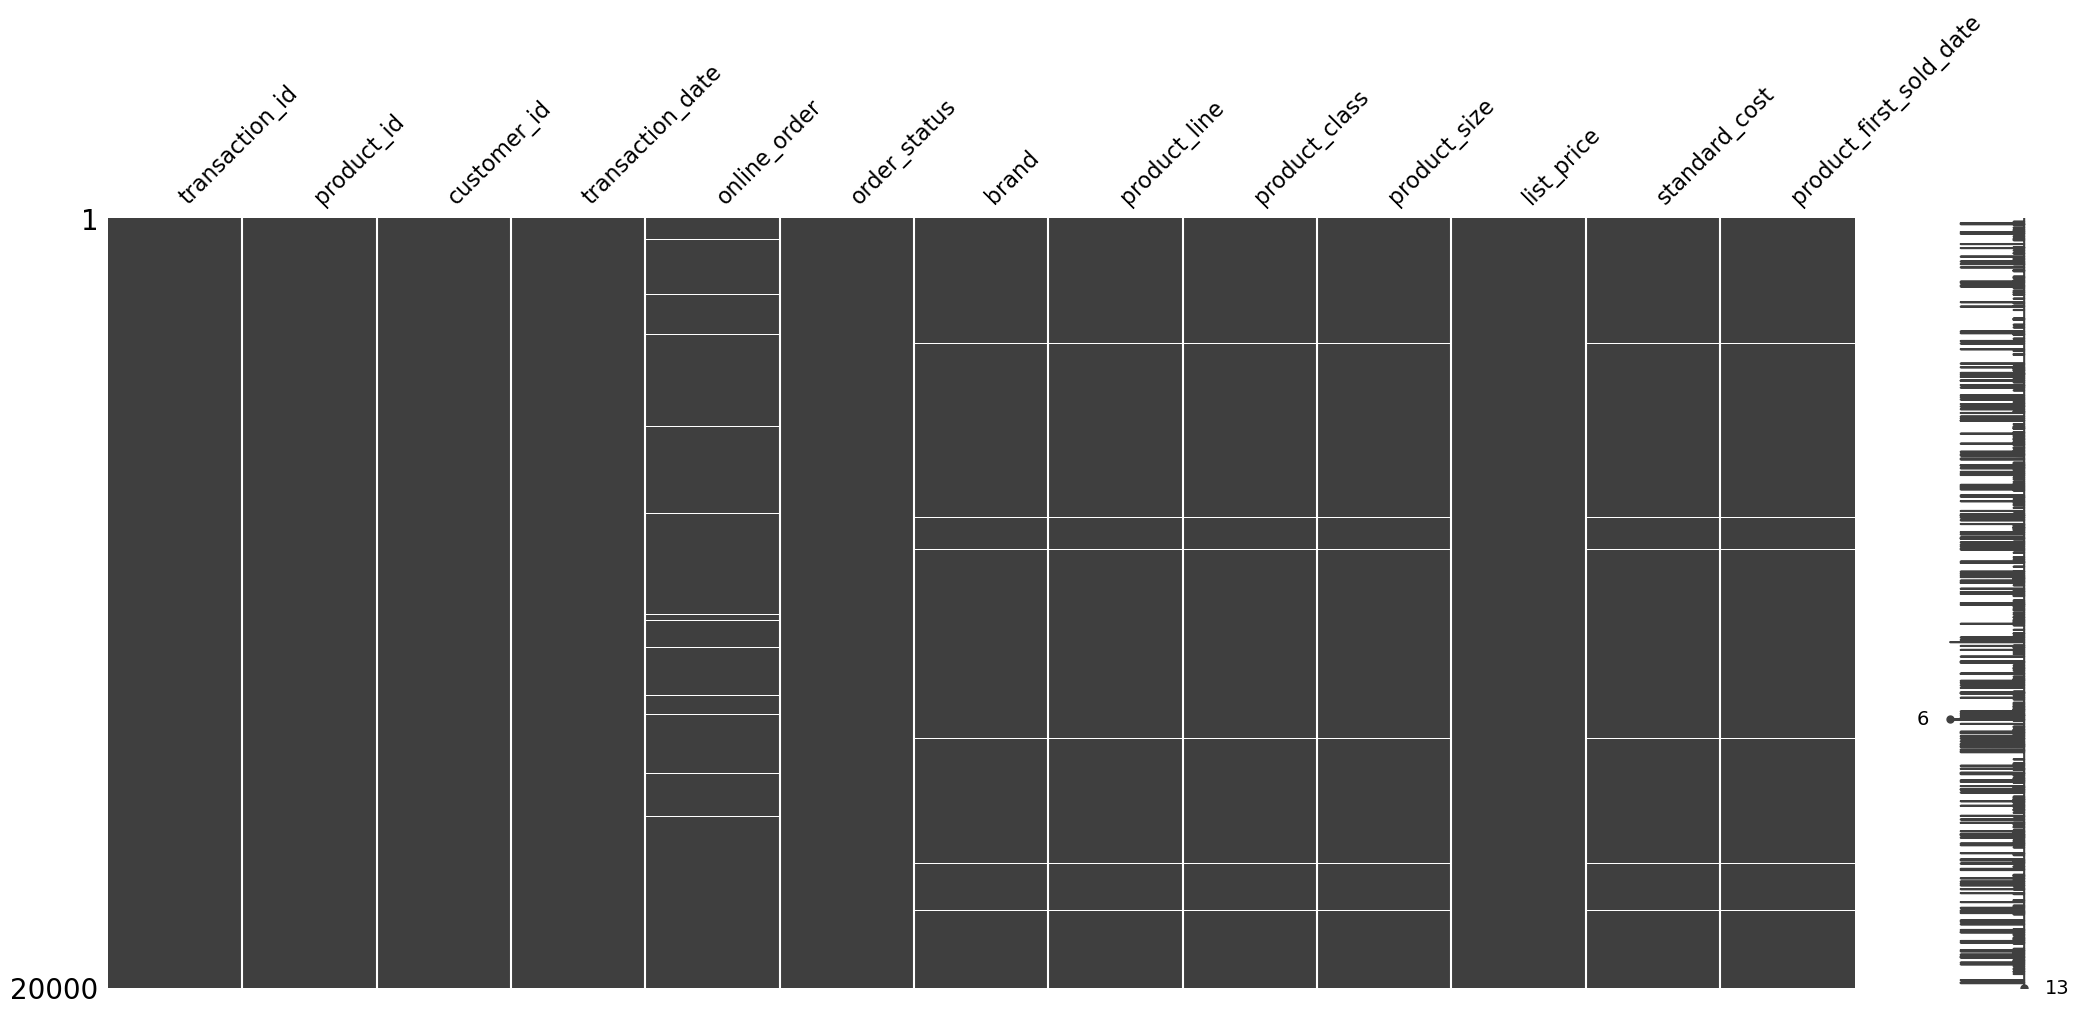

In [89]:
# exploring missingness
missingness = df_transactions_cleaned.isna().mean()
print(f"Dataset missingness: {100*missingness.mean():.1f}%")
print(missingness*100)

msno.matrix(df_transactions_cleaned)

In [90]:
# listwise deletion for missing brands, product attributes and prices (197 records)
df_transactions_cleaned.dropna(subset='brand', how='any', inplace=True)
# impute 'unspecified' category to online_order (358 null values)
df_transactions_cleaned['online_order'] = df_transactions_cleaned['online_order'].cat.add_categories('unspecified')
df_transactions_cleaned['online_order'].fillna(value='unspecified', inplace=True)

In [91]:
df_transactions_cleaned.describe()

,list_price,standard_cost
count,19803.000000,19803.000000
mean,1107.997866,556.046951
std,582.770460,405.955660
min,12.010000,7.210000
25%,575.270000,215.140000
50%,1163.890000,507.580000
75%,1635.300000,795.100000
max,2091.470000,1759.850000


In [92]:
df_transactions['brand'].value_counts()

Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64

In [93]:
# added profit column
df_transactions_cleaned['profit'] = df_transactions_cleaned['list_price']-df_transactions_cleaned['standard_cost']

### dim_Demographics

Summary:

* 4000 distinct customers in the dataset before cleaning
* no duplicated records
* Gender represented by not allowable values (misspellings), which I replaced with F/M
* Missing data: 497 job_title, 656 job_industry_category, 125 last_name
* DOB doesn't match range constraint: its 1843-12-21 indicated for 1 customer (removed)
* default column is not interpretable, thus dropped out

In [34]:
df_demographic.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [35]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [94]:
df_demographic_cleaned = df_demographic.copy(deep=True)

In [95]:
# numeric to categories
df_demographic_cleaned['customer_id']=df_demographic_cleaned['customer_id'].astype('category')

Dataset missingness: 3.4%
customer_id                             0.000
first_name                              0.000
last_name                               3.125
gender                                  0.000
past_3_years_bike_related_purchases     0.000
DOB                                     2.175
job_title                              12.650
job_industry_category                  16.400
wealth_segment                          0.000
deceased_indicator                      0.000
default                                 7.550
owns_car                                0.000
tenure                                  2.175
dtype: float64


<Axes: >

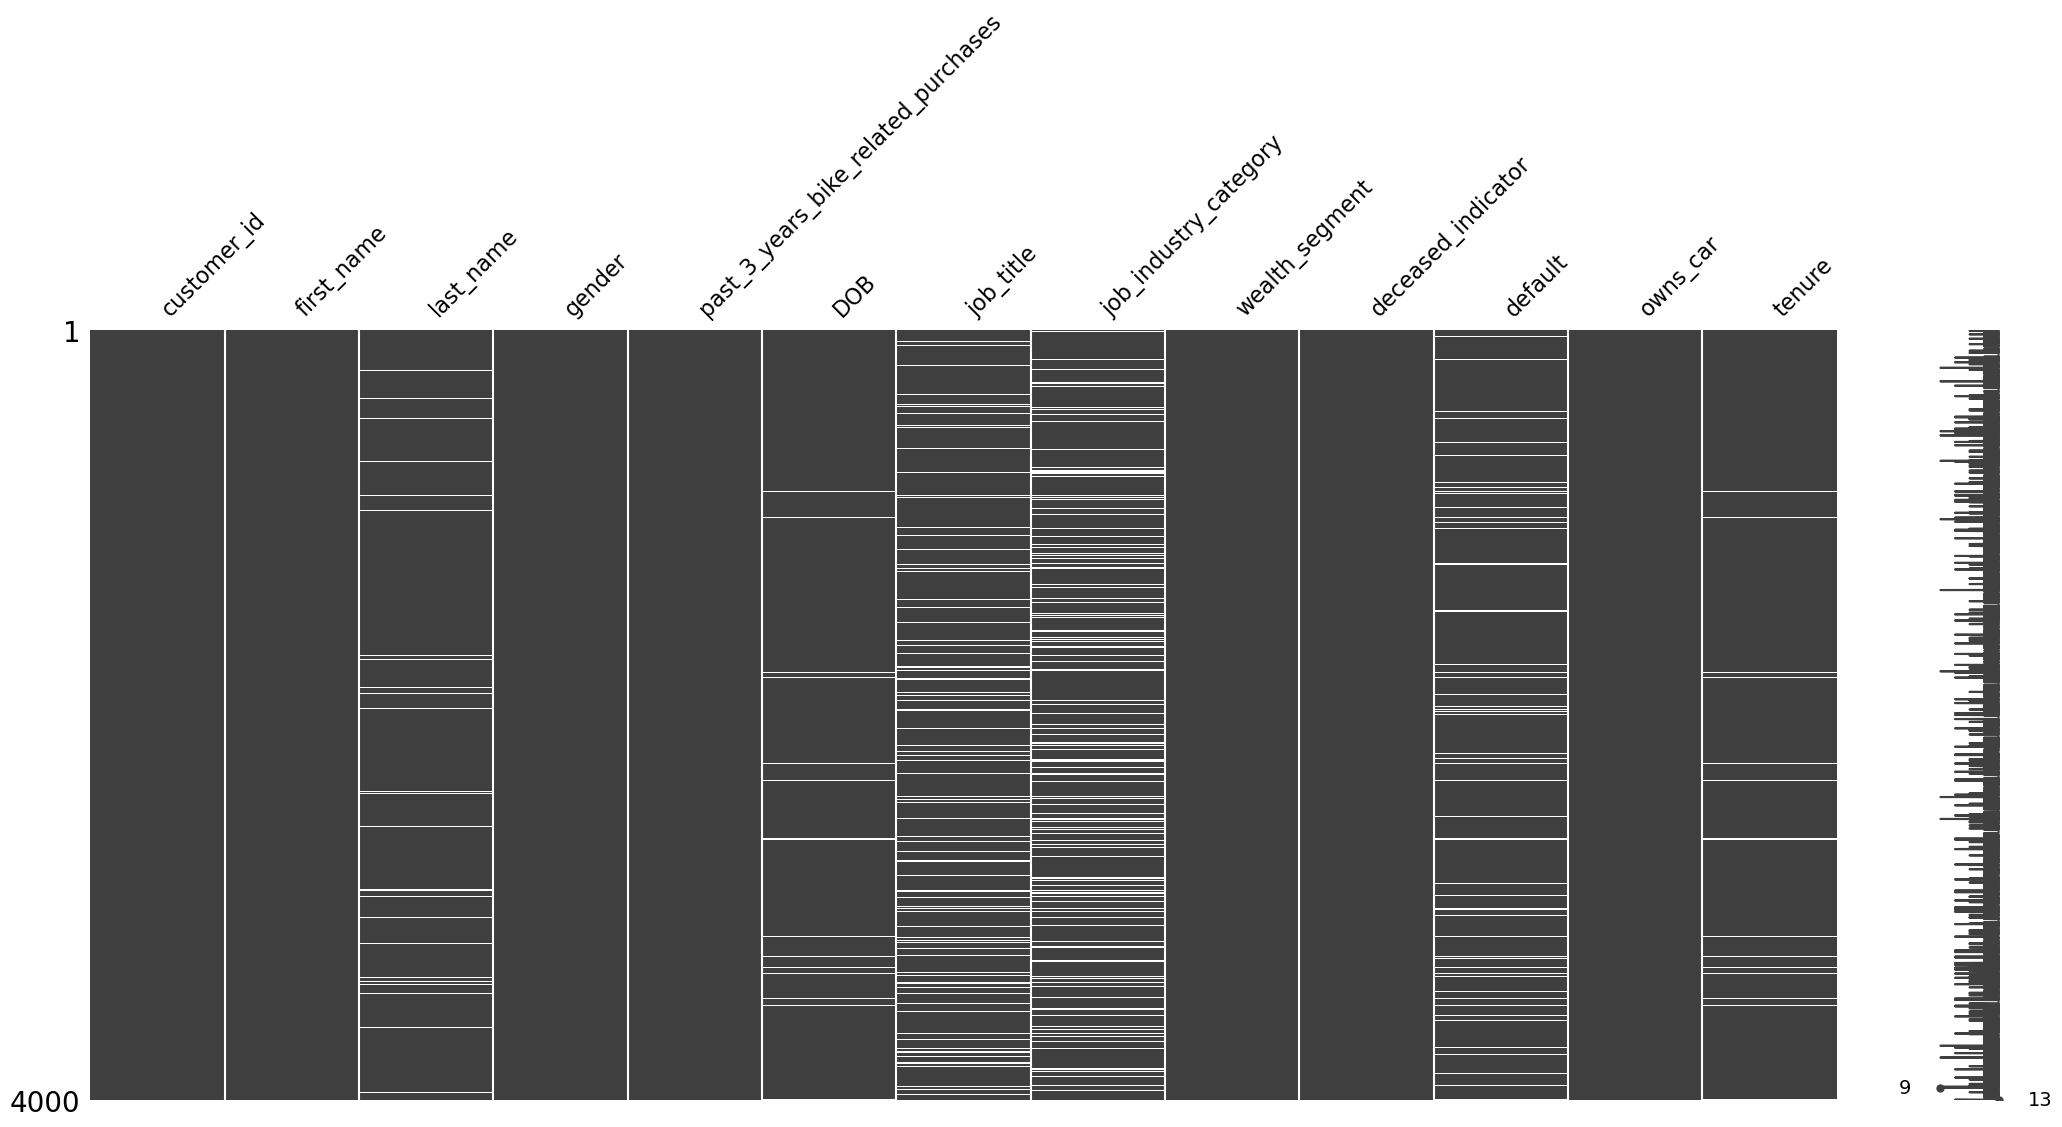

In [96]:
# assessing missingness
missingness = df_demographic_cleaned.isna().mean()
print(f"Dataset missingness: {100*missingness.mean():.1f}%")
print(missingness*100)

msno.matrix(df_demographic_cleaned)

In [97]:
# subsetting dataset
filter_cond_1 = df_demographic_cleaned['deceased_indicator']!='Y'
filter_cond_2 = df_demographic_cleaned['DOB'].dt.year > 1900
df_demographic_cleaned = df_demographic_cleaned[(filter_cond_1)&(filter_cond_2)]
drop_columns = ['first_name', 'last_name','job_title', 'deceased_indicator', 'default']
df_demographic_cleaned = df_demographic_cleaned.drop(drop_columns, axis=1)

In [98]:
df_demographic_cleaned['gender'].value_counts()

Female    2036
Male      1871
F            1
Femal        1
M            1
Name: gender, dtype: int64

In [99]:
# values substitute 
df_demographic_cleaned['job_industry_category'].fillna('unspecified', inplace=True)
df_demographic_cleaned['gender'] = df_demographic_cleaned['gender'].replace(['Female', 'F', 'Femal'], 'F', regex=True)
df_demographic_cleaned['gender'] = df_demographic_cleaned['gender'].replace(['Male', 'M'], 'M', regex=True)
df_demographic_cleaned['gender'] = df_demographic_cleaned['gender'].astype('category')

In [100]:
# defining age bins
df_demographic_cleaned['age'] = df_demographic_cleaned['DOB'].apply(age)
bins = [0,10,20,30,40,50,60,70,80,90,100]
df_demographic_cleaned['age_group'] = pd.cut(df_demographic_cleaned['age'], bins=bins)

In [357]:
df_demographic_cleaned.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_group
0,1,F,93,1953-10-12,Health,Mass Customer,Yes,11.0,69,"(60, 70]"
1,2,M,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,42,"(40, 50]"
2,3,M,61,1954-01-20,Property,Mass Customer,Yes,15.0,69,"(60, 70]"
3,4,M,33,1961-10-03,IT,Mass Customer,No,7.0,61,"(60, 70]"
4,5,F,56,1977-05-13,unspecified,Affluent Customer,Yes,8.0,46,"(40, 50]"


### dim_Address

Summary:
* There are 3999 customers with adderesses
* No duplicates
* no missing values
* renamed states 'New South Wales' with existing spelling NSW and 'Victoria' with VIC
* lack of context on property_valuation column

In [83]:
df_address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [84]:
df_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [102]:
df_address_cleaned = df_address.copy(deep=True)

In [103]:
df_address_cleaned['state'].value_counts()

NSW                2054
VIC                 939
QLD                 838
New South Wales      86
Victoria             82
Name: state, dtype: int64

In [104]:
# converting numeric to categories
columns = ['customer_id', 'postcode']
df_address_cleaned[columns] = df_address_cleaned[columns].astype('category')

In [105]:
# cleaning states
states = {'New South Wales':'NSW',
          'Victoria':'VIC'}
df_address_cleaned['state'] = df_address_cleaned['state'].replace(states)

In [106]:
# drop columns
df_address_cleaned=df_address_cleaned.drop(['address', 'country'], axis=1)

### Model dataset

In [107]:
# merging fact table with dim data using customer_id as key
df_model = df_transactions_cleaned.merge(df_demographic_cleaned, how='inner', on='customer_id')
df_model = df_model.merge(df_address_cleaned, how='inner', on='customer_id')

customers_nmb = df_model['customer_id'].nunique()
customers_prcnt = 100*customers_nmb/unique_customer_ids_transactions
print(f'# of customers in the model set: {customers_nmb} out of {unique_customer_ids_transactions} from the original data set, which is {customers_prcnt:.1f}%')

# of customers in the model set: 3411 out of 3494 from the original data set, which is 97.6%


In [110]:
df_model.to_pickle('df_model')
df_model.to_csv('df_model.csv')

## Data Insights

In [111]:
df_model = pd.read_pickle('df_model')

In [112]:
df_model.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,profit,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_group,postcode,state,property_valuation
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02,17.87,M,19,1955-01-11,Financial Services,Mass Customer,Yes,10.0,68,"(60, 70]",3064,VIC,6
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,2003-02-07,448.68,M,19,1955-01-11,Financial Services,Mass Customer,Yes,10.0,68,"(60, 70]",3064,VIC,6
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,478.16,298.72,2010-11-05,179.44,M,19,1955-01-11,Financial Services,Mass Customer,Yes,10.0,68,"(60, 70]",3064,VIC,6
3,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03,1702.55,F,89,1979-02-04,Health,Mass Customer,Yes,10.0,44,"(40, 50]",2196,NSW,5
4,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,medium,1129.13,677.48,2011-04-16,451.65,F,89,1979-02-04,Health,Mass Customer,Yes,10.0,44,"(40, 50]",2196,NSW,5


In [113]:
df_model.describe()

,list_price,standard_cost,profit,past_3_years_bike_related_purchases,tenure,age,property_valuation
count,19319.000000,19319.000000,19319.000000,19319.000000,19319.000000,19319.000000,19319.000000
mean,1106.288029,555.762173,550.525856,48.923443,10.682437,45.514364,7.517884
std,582.864043,405.692537,492.915216,28.642610,5.673114,12.607336,2.825970
min,12.010000,7.210000,4.800000,0.000000,1.000000,21.000000,1.000000
25%,575.270000,215.140000,133.780000,24.000000,6.000000,36.000000,6.000000
50%,1163.890000,507.580000,445.210000,48.000000,11.000000,45.000000,8.000000
75%,1635.300000,795.100000,827.160000,73.000000,15.000000,55.000000,10.000000
max,2091.470000,1759.850000,1702.550000,99.000000,22.000000,91.000000,12.000000


In [5]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19319 entries, 0 to 19318
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_id                       19319 non-null  int64  
 1   product_id                           19319 non-null  int64  
 2   customer_id                          19319 non-null  int64  
 3   transaction_date                     19319 non-null  object 
 4   online_order                         19319 non-null  object 
 5   order_status                         19319 non-null  object 
 6   brand                                19319 non-null  object 
 7   product_line                         19319 non-null  object 
 8   product_class                        19319 non-null  object 
 9   product_size                         19319 non-null  object 
 10  list_price                           19319 non-null  float64
 11  standard_cost               

### Products

Text(0, 0.5, 'thsnd. USD$')

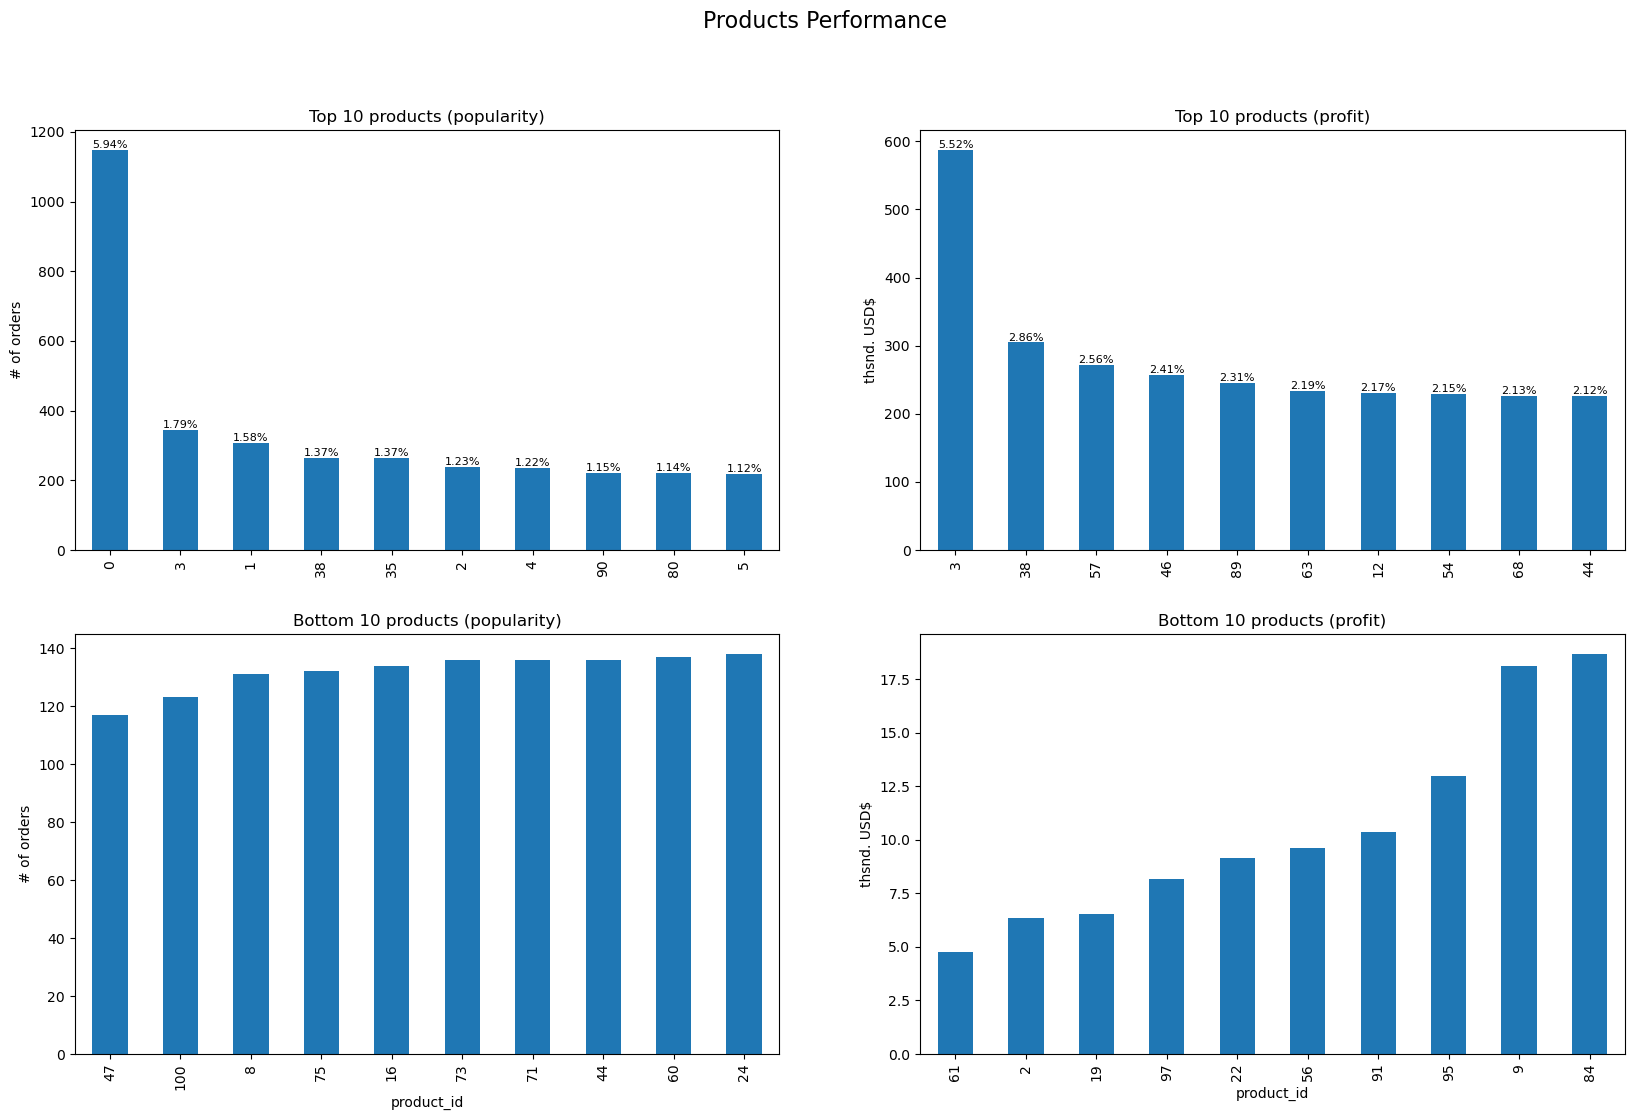

In [6]:
# TOP and BOTTOM Products -------------------------------------------------------------------

products_performance = df_model.groupby(by='product_id').agg({'transaction_id':'count', 'profit':'sum'}) \
                                                        .rename(columns = {"transaction_id":"# of orders", "profit": "profit, USD$"})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Products Performance', fontsize=16)

# TOP Number of orders
ax1 = axes[0, 0]
products_performance['# of orders'].sort_values(ascending=False) \
                                    .head(10) \
                                    .plot(kind='bar', ax=ax1)
ax1.set_title('Top 10 products (popularity)')
ax1.set_xlabel('')
ax1.set_ylabel('# of orders')

product_counts = df_model['product_id'].value_counts().head(10)
product_percentage = (product_counts / len(df_model)) * 100
for i, count in enumerate(product_counts):
    percentage = product_percentage[product_counts.index[i]]
    ax1.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

# TOP profit
ax2 = axes[0, 1]
products_performance['profit, thousand USD$'] = products_performance['profit, USD$']/1000
products_performance['profit, thousand USD$'].sort_values(ascending=False) \
                                    .head(10) \
                                    .plot(kind='bar', ax=ax2)
ax2.set_title('Top 10 products (profit)')
ax2.set_xlabel('')
ax2.set_ylabel('thsnd. USD$')

profit_counts = products_performance['profit, thousand USD$'].sort_values(ascending=False).head(10)
profit_percentage = (profit_counts / products_performance['profit, thousand USD$'].sum()) * 100
for i, count in enumerate(profit_counts):
    percentage = profit_percentage[profit_counts.index[i]]
    ax2.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

# Bottom Number of orders
ax3 = axes[1, 0]
products_performance['# of orders'].sort_values(ascending=True) \
                                    .head(10) \
                                    .plot(kind='bar', ax=ax3)
ax3.set_title('Bottom 10 products (popularity)')
ax3.set_xlabel('product_id')
ax3.set_ylabel('# of orders')

# Bottom profit
ax4 = axes[1, 1]
products_performance['profit, thousand USD$'] = products_performance['profit, USD$']/1000
products_performance['profit, thousand USD$'].sort_values(ascending=True) \
                                    .head(10) \
                                    .plot(kind='bar', ax=ax4)
ax4.set_title('Bottom 10 products (profit)')
ax4.set_xlabel('product_id')
ax4.set_ylabel('thsnd. USD$')

In [866]:
# Product Performance ------------------------------------

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Orders
fig.add_trace(
    go.Bar(
        x=products_performance.index,
        y=products_performance['# of orders'],
        marker_color='#4789B3',
        name='# of orders'
    )
)

# Profit
fig.add_trace(
    go.Scatter(
        x=products_performance.index,
        y=products_performance['profit, thousand USD$'],
        mode='lines',
        line=dict(color='orange', width=2),
        name='Profit'
    ),
    secondary_y=True,
)

# notes
note_text_1 = 'Most Popular: product_id = 0 is responsible for 6% of orders'
note_text_2 = 'Most Valuable: product_id = 3 is responsible for 6% of total profit'
fig.add_annotation(text=note_text_1,x=0.01,y=0.8,xref="paper",yref="paper",font=dict(size=12),showarrow=False,bgcolor="lightgrey")
fig.add_annotation(text=note_text_2, x=0.04,y=0.93,xref="paper",yref="paper",font=dict(size=12),showarrow=False,bgcolor="lightgrey")

# layout
fig.update_layout(
    title='Product Performance: Orders and Profit',
    xaxis_title='Product ID',
    yaxis_title='# of orders',
    yaxis2_title='Profit, thsnd. USD$',
    xaxis_tickangle=-90,
    xaxis=dict(showline=True, linewidth=1, linecolor='black',tickfont=dict(size=10), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    yaxis2=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    showlegend=True,
    legend=dict(x=0.7, y=1.0,font=dict(size=14)),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    width=1400
)

# Show the plot
fig.show()

In [865]:
# Brands Performance ------------------------------------

brands_performance = df_model.groupby(by='brand').agg({'transaction_id':'count', 'profit':'sum'}) \
                                                        .rename(columns = {"transaction_id":"# of orders", "profit": "profit, USD$"}) \
                                                        .reset_index()
brands_performance['profit, thousand USD$'] = round(brands_performance['profit, USD$']/1000)

brand_order = sorted(df_model['brand'].unique())

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Orders
fig.add_trace(
    go.Bar(
        x=brands_performance['brand'],
        y=brands_performance['# of orders'],
        marker_color='#4789B3',
        name='# of orders'
    )
)

# Profit
fig.add_trace(
    go.Scatter(
        x=brands_performance['brand'],
        y=brands_performance['profit, thousand USD$'],
        mode='lines',
        line=dict(color='orange', width=2),
        name='Profit'
    ),
    secondary_y=True,
)

# layout
fig.update_layout(
    title='Brands Performance: Orders and Profit',
    xaxis_title='',
    yaxis_title='# of orders',
    yaxis2_title='Profit, thsnd. USD$',
    xaxis_tickangle=-45,
    xaxis=dict(showline=True, linewidth=1, linecolor='black',tickfont=dict(size=12), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    yaxis2=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    showlegend=True,
    legend=dict(x=0.05, y=1.1,font=dict(size=12)),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=400,
    width=600
)

# Show the plot
fig.show()

In [864]:
# Product Class Popularity ------------------------------------

class_performance = df_model.groupby(by=['brand','product_class'])['transaction_id'].count().reset_index()
class_performance.rename(columns={'transaction_id':'# of orders'}, inplace=True)

brand_order = sorted(df_model['brand'].unique())

color_map = {
    'high': '#1F3B4D',
    'medium': '#4789B3',
    'low': '#57A7D9'
}

# Brands and Product Class Popularity
fig_class = px.bar(
    class_performance,
    x='brand',
    y='# of orders',
    color='product_class',
    title='Brand and Classes Popularity',
    labels={'brand': '', '# of orders': 'Number of Orders', 'product_class': 'Product Class'},
    barmode='group',
    color_discrete_map=color_map
)

fig_class.update_layout(
    showlegend=True,
    height=400,
    width=600,
    title_x=0.5,
    xaxis=dict(tickangle=-45, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=12), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_class.show()

In [860]:
# Continuos color scale solution ----------------------------

colorscale = [
    [0, '#57A7D9'],
    [0.25, '#539ECD'],
    [0.5, '#4789B3'],
    [0.75, '#386C8C'],
    [1, '#1F3B4D']
]

# Brands performance
fig_brand_performance = px.bar(
    brands_performance,
    x='brand',
    y='# of orders',
    hover_data=['brand', '# of orders', 'profit, thousand USD$'],
    color='profit, thousand USD$',
    title='Brand Performance Analysis',
    labels={'brand': '', '# of orders': 'Number of Orders', 'profit, thousand USD$': 'Profit (thsnd.USD$)'},
    color_continuous_scale=colorscale
)

fig_brand_performance.update_layout(
    showlegend=False,
    height=400,
    width=600,
    title_x=0.5,
    xaxis=dict(tickangle=0),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_tickangle=-45
)

fig_brand_performance.show()

Notes:
* Among all products, product_id=0 is the most popular item responsible for 6% of all orders, however less then 1% of total income
* Whereas The most valuable product is product_id=3 responsible for 6% of total income
* The most popular brand is Silex, while the most valuable is WeareA2B
* The most popular and valuable product_class among all brands is medium

### Customers and Orders

In [175]:
# Age groups -------------------------------------------------

age_counts = df_model['age_group'].value_counts()
age_percentage = (age_counts / age_counts.sum()) * 100

age_counts.index = age_counts.index.astype(str)
custom_sort_order = age_counts.index

fig_age = px.bar(x=age_counts.index, y=age_counts, orientation='v')
fig_age.update_layout(
    title='Age Groups',
    xaxis_title='',
    yaxis_title='# of orders',
    height=400,
    width=900,
    xaxis=dict(tickangle=-0, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=12), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_age.update_traces(marker_color='#4789B3')

for age_group, count, percentage in zip(age_counts.index, age_counts, age_percentage):
    fig_age.add_annotation(
        text=f'{percentage:.1f}%',
        x=age_group,
        y=count,
        yanchor='bottom',
        showarrow=False
    )

fig_age.show()


In [176]:
# States -------------------------------------------------------------------

state_counts = df_model['state'].value_counts()
state_percentages = (state_counts / state_counts.sum()) * 100

fig_state = px.bar(x=state_counts.index, y=state_counts)
fig_state.update_layout(
    title='States',
    xaxis_title='',
    yaxis_title='# of orders',
    height=400,
    width=600,
    xaxis=dict(tickangle=0, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=10), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_state.update_traces(marker_color='#4789B3')

for i, count, percentage in zip(range(len(state_counts)), state_counts, state_percentages):
    fig_state.add_annotation(
        text=f'{percentage:.1f}%', 
        x=state_counts.index[i],
        y=count,
        yanchor='bottom',
        showarrow=False
    )

fig_state.show()

In [179]:
# Gender ---------------------------------------------------------

gender_counts = df_model['gender'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

fig_gender = px.bar(x=gender_counts.index, y=gender_counts)
fig_gender.update_layout(
    title='Gender',
    xaxis_title='',
    yaxis_title='# of orders',
    height=400,
    width=600,
    xaxis=dict(tickangle=0, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=12), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_gender.update_traces(marker_color='#4789B3')

for i, count, percentage in zip(range(len(gender_counts)), gender_counts, gender_percentages):
    fig_gender.add_annotation(
        text=f'{percentage:.1f}%',
        x=gender_counts.index[i],
        y=count,
        yanchor='bottom',
        showarrow=False
    )

fig_gender.show()


In [177]:
# Job Industry ------------------------------------------

industry_counts = df_model['job_industry_category'].value_counts()
industry_percentages = (industry_counts / industry_counts.sum()) * 100

fig_industry = px.bar(y=industry_counts.index, x=industry_counts, orientation='h')
fig_industry.update_layout(
    title='Job Industry',
    xaxis_title='# of orders',
    yaxis_title='',
    height=400,
    width=900,
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_industry.update_traces(marker_color='#4789B3')

for industry, count, percentage in zip(industry_counts.index, industry_counts, industry_percentages):
    fig_industry.add_annotation(
        text=f'{percentage:.1f}%',
        x=count,
        y=industry,
        xanchor='left',
        showarrow=False
    )
    
fig_industry.show()

Notes:
* NSQ responsible for 53.4% of orders, followed by VIC and QLD (25.2% and 21.4% respectfully)
* 52% of orders came from customers of (40,60] Age group, followed by (20,40] group with 33% of orders.
* While 16% of customers did not specified assocciated job industry, the most occured job industries belong to Manufacturing and Financial Siervises (20% of orders for each)
* Female customers make slightly more transactions than male customers over the past three years (51.2% and 48.8% of orders accordingly).

In [251]:
# Explore Wealth Segments
pygwalker.walk(df_model)

Box(children=(HTML(value='<div id="ifr-pyg-1" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

In [283]:
wealth_segment_profit = df_model.groupby('wealth_segment')['profit'].sum().reset_index()

fig_wealth_segment_profit = px.pie(names=wealth_segment_profit['wealth_segment'], values=wealth_segment_profit['profit'])

color_map = ('#57A7D9', '#4789B3', '#1F3B4D')

fig_wealth_segment_profit.update_layout(
    title='Total Profit within Wealth Segment',
    height=400,
    width=500,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(color='black'),
)
fig_wealth_segment_profit.update_traces(marker=dict(colors=color_map))
fig_wealth_segment_profit.show()

Notes:
* the most valuable wealth segment is Mass Customers (in both # of orders and profit) for age groups, gender, state

In [282]:
property_valuation = df_model['property_valuation'].value_counts()
property_valuation_percentages = (property_valuation / property_valuation.sum()) * 100

fig_property_valuation = px.bar(x=property_valuation.index, y=property_valuation)

fig_property_valuation.update_layout(
    title='Property Valuation Distribution',
    xaxis_title='property valuation',
    yaxis_title='# of orders',
    height=400,
    width=600,
    xaxis=dict(tickangle=0, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=12), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_property_valuation.update_traces(marker_color='#4789B3')

for i, count, percentage in zip(range(len(property_valuation)), property_valuation, property_valuation_percentages):
    fig_property_valuation.add_annotation(
        text=f'{percentage:.0f}%',
        x=property_valuation.index[i],
        y=count,
        yanchor='bottom',
        showarrow=False
    )

fig_property_valuation.show()

In [221]:
# Age and Gender ------------------------------------

color_map = {
    'F': 'orange', 
    'M': '#4789B3',
}

df_age_gender = df_model.groupby(by=['age_group', 'gender'])['transaction_id'].count().reset_index()
df_age_gender['age_group'] = df_age_gender['age_group'].astype(str)

fig_age_gender = px.bar(
    df_age_gender, 
    x='age_group', 
    y = 'transaction_id',
    color='gender', 
    title='Age and Gender Distribution',
    labels={'age_group': '', 'gender': 'Gender', 'transaction_id': '# of orders'},
    color_discrete_map=color_map,
    barmode='group')

fig_age_gender.update_layout(
    showlegend=True,
    height=400,
    width=600,
    # title_x=0.5,
    xaxis=dict(tickangle=0, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=10), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_age_gender.show()

In [276]:
# Car owners ------------------------------------

color_map = {
    'Yes': '#1F3B4D', 
    'No': '#4789B3',
}

df_cars = df_model.groupby(by=['state', 'owns_car'])['transaction_id'].count().reset_index()

fig_car = px.bar(
    df_cars, 
    x='state', 
    y = 'transaction_id',
    color='owns_car', 
    title='State and Car Owners Distribution',
    labels={'state': '', 'owns_car': 'Car Ownership', 'transaction_id': '# of orders'},
    color_discrete_map=color_map,
    barmode='group')

fig_car.update_layout(
    showlegend=True,
    height=400,
    width=600,
    title_x=0.5,
    xaxis=dict(tickangle=0, showline=True, linewidth=1, linecolor='black',tickfont=dict(size=12), tickmode='linear'),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    font=dict(color='black'),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig_car.show()

In [284]:
# Bike-related purchases
df_purchases = df_model.groupby(by=['customer_id'])['past_3_years_bike_related_purchases'].max().reset_index()
# df_purchases.head()
fig = px.histogram(df_purchases, x='past_3_years_bike_related_purchases', nbins=20,
                   title='Distribution of Bike Related Purchases',
                   labels={'past_3_years_bike_related_purchases': 'Bike Related Purchases Count', 'count': 'Frequency'})

fig.update_layout(
    xaxis=dict(title='Bike Related Purchases Count'),
    yaxis=dict(title='Frequency'),
    showlegend=False,
    height=400,
    width=600,
    title_x=0.5,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(color='black')
)

fig.update_traces(marker_color='#4789B3')

fig.show()

In [70]:
# Customer Purchase Frequency Distribution -------------------------------------------

purchase_frequency = df_model.groupby('customer_id')['transaction_id'].count().reset_index()
customer_counts = purchase_frequency['transaction_id'].value_counts(normalize=True).sort_index()

cumulative_percentage = customer_counts.cumsum()

fig = go.Figure()

# Add bar trace
fig.add_trace(
    go.Bar(
        x=customer_counts.index,
        y=customer_counts.values * 100,
        marker_color='#4789B3',
        name='Customer %',
        text=[f'{val:.1f}%' for val in customer_counts.values * 100],
    )
)

# cumulative percentage
fig.add_trace(
    go.Scatter(
        x=customer_counts.index,
        y=cumulative_percentage.values * 100,
        mode='lines',
        line=dict(color='orange', width=2),
        name='Cumulative %',
        yaxis='y2', 
    )
)

fig.update_layout(
    title='Customer Purchase Frequency Distribution',
    xaxis_title='Number of transactions',
    yaxis_title='',
    yaxis2=dict(
        title='% Cumulative Customers',
        overlaying='y',
        side='right'
    ),
    showlegend=True,
    legend=dict(x=0.02, y=1.1),
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(tickmode='linear', dtick=1),
    yaxis=dict(showticklabels=False),
    font=dict(color='black') 
)

fig.show()

Notes:
* the chart indicates that making 5 transactions is the most frequent behavior among customers.
* 50% of all customers make more than 5 transactions


### Sales and Transactions Trend

In [374]:
# General Monthly Overview ------------------------------------------------------------

df_model['Month'] = df_model['transaction_date'].dt.month

df_trends = df_model.groupby(by='Month') \
                    .agg({'transaction_id':'count', 'list_price':'sum', 'profit':'sum'}) \
                    .rename(columns={'transaction_id':'orders_nmb', 'list_price':'total_sales', 'profit':'total_profit'})

# Create a subplot grid with 2 rows and 1 column
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=("Number of Orders","Sales and Profit"))

# Adding stacked bar traces for sales and profit to the first subplot
fig.add_trace(go.Bar(x=df_trends.index, y=df_trends['total_sales'], name='Total Sales', marker_color='#1F3B4D'), row=2, col=1)
fig.add_trace(go.Bar(x=df_trends.index, y=df_trends['total_profit'], name='Total Profit', marker_color='#4789B3'), row=2, col=1)

# Adding a line chart for number of orders to the second subplot
fig.add_trace(go.Scatter(x=df_trends.index, y=df_trends['orders_nmb'], mode='lines+markers', name='Number of Orders', line=dict(color='orange')), row=1, col=1)

# Update y-axis range for the second subplot to start from 0
fig.update_yaxes(range=[0, 3000], row=1, col=1)

custom_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig.update_layout(title_text="Monthly Overview", plot_bgcolor='rgba(0,0,0,0)', font=dict(color='black'))
fig.update_xaxes(tickmode='array', tickvals=df_trends.index, ticktext=custom_labels)
fig.update_yaxes(title_text="$USD", secondary_y=False, row=2, col=1)
fig.update_yaxes(title_text="Number of Orders", secondary_y=False, row=1, col=1)

fig.show()

In [372]:
import pandas as pd

# Assuming you have df_trends already calculated

# Calculate descriptive statistics
numeric_stats = df_trends.describe()

# Find month with maximum values
max_month_sales = df_trends['total_sales'].idxmax()
max_month_profit = df_trends['total_profit'].idxmax()
max_month_orders = df_trends['orders_nmb'].idxmax()

# Find month with minimum values
min_month_sales = df_trends['total_sales'].idxmin()
min_month_profit = df_trends['total_profit'].idxmin()
min_month_orders = df_trends['orders_nmb'].idxmin()

# Print the descriptive statistics
print("Statistics:")
print(numeric_stats)
print("\nMonth with Maximum Values:")
print(f"Total Sales: {max_month_sales}")
print(f"Total Profit: {max_month_profit}")
print(f"Number of Orders: {max_month_orders}")
print("\nMonth with Minimum Values:")
print(f"Total Sales: {min_month_sales}")
print(f"Total Profit: {min_month_profit}")
print(f"Number of Orders: {min_month_orders}")


Descriptive Statistics:
        orders_nmb   total_sales   total_profit
count    12.000000  1.200000e+01      12.000000
mean   1609.916667  1.781032e+06  886300.750833
std      59.599357  7.108370e+04   41892.306422
min    1518.000000  1.682966e+06  831742.420000
25%    1583.250000  1.734075e+06  853409.700000
50%    1605.500000  1.766426e+06  887810.335000
75%    1640.750000  1.825823e+06  905536.725000
max    1718.000000  1.909207e+06  969765.820000

Month with Maximum Values:
Total Sales: 10
Total Profit: 10
Number of Orders: 10

Month with Minimum Values:
Total Sales: 6
Total Profit: 6
Number of Orders: 9


## Compare Model and Test datasets

In [11]:
df_newcustomer.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'],
      dtype='object')

In [26]:
df_newcustomer_cleaned = df_newcustomer.copy(deep=True)

In [27]:
df_newcustomer_cleaned['age'] = df_newcustomer_cleaned['DOB'].apply(age)

In [24]:
df_model=pd.read_csv('df_model.csv')
df_model.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'profit', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_industry_category',
       'wealth_segment', 'owns_car', 'tenure', 'age', 'age_group', 'postcode',
       'state', 'property_valuation'],
      dtype='object')

In [35]:
compare_fields = ['gender', 'age', 'state', 'past_3_years_bike_related_purchases', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'property_valuation']
compare_report = sv.compare([df_model[compare_fields], 'Current Customers'], [df_newcustomer_cleaned[compare_fields], 'New Customers'])
compare_report.show_html('compare.html', open_browser = True)

c:\Users\timos\anaconda3\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\timos\anaconda3\lib\site-packages\sweetviz\dataframe_report.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_compare_names = [cur_name for cur_name, cur_series in compare_df.iteritems()]
c:\Users\timos\anaconda3\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

c:\Users\timos\anaconda3\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\timos\anaconda3\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
c:\Users\timos\anaconda3\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
c:\Users\timos\anaconda3\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\tim

Report compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
